# Task for Today  

***

## Fetal Health Prediction  

Given *data about fetuses*, let's try to predict the **health** of a given fetus.

We will use a variety of classification models to make our predictions.

# Getting Started

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('../input/fetal-health-classification/fetal_health.csv')

In [3]:
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

# Exploratory Data Analysis

In [5]:
eda_df = data.copy()

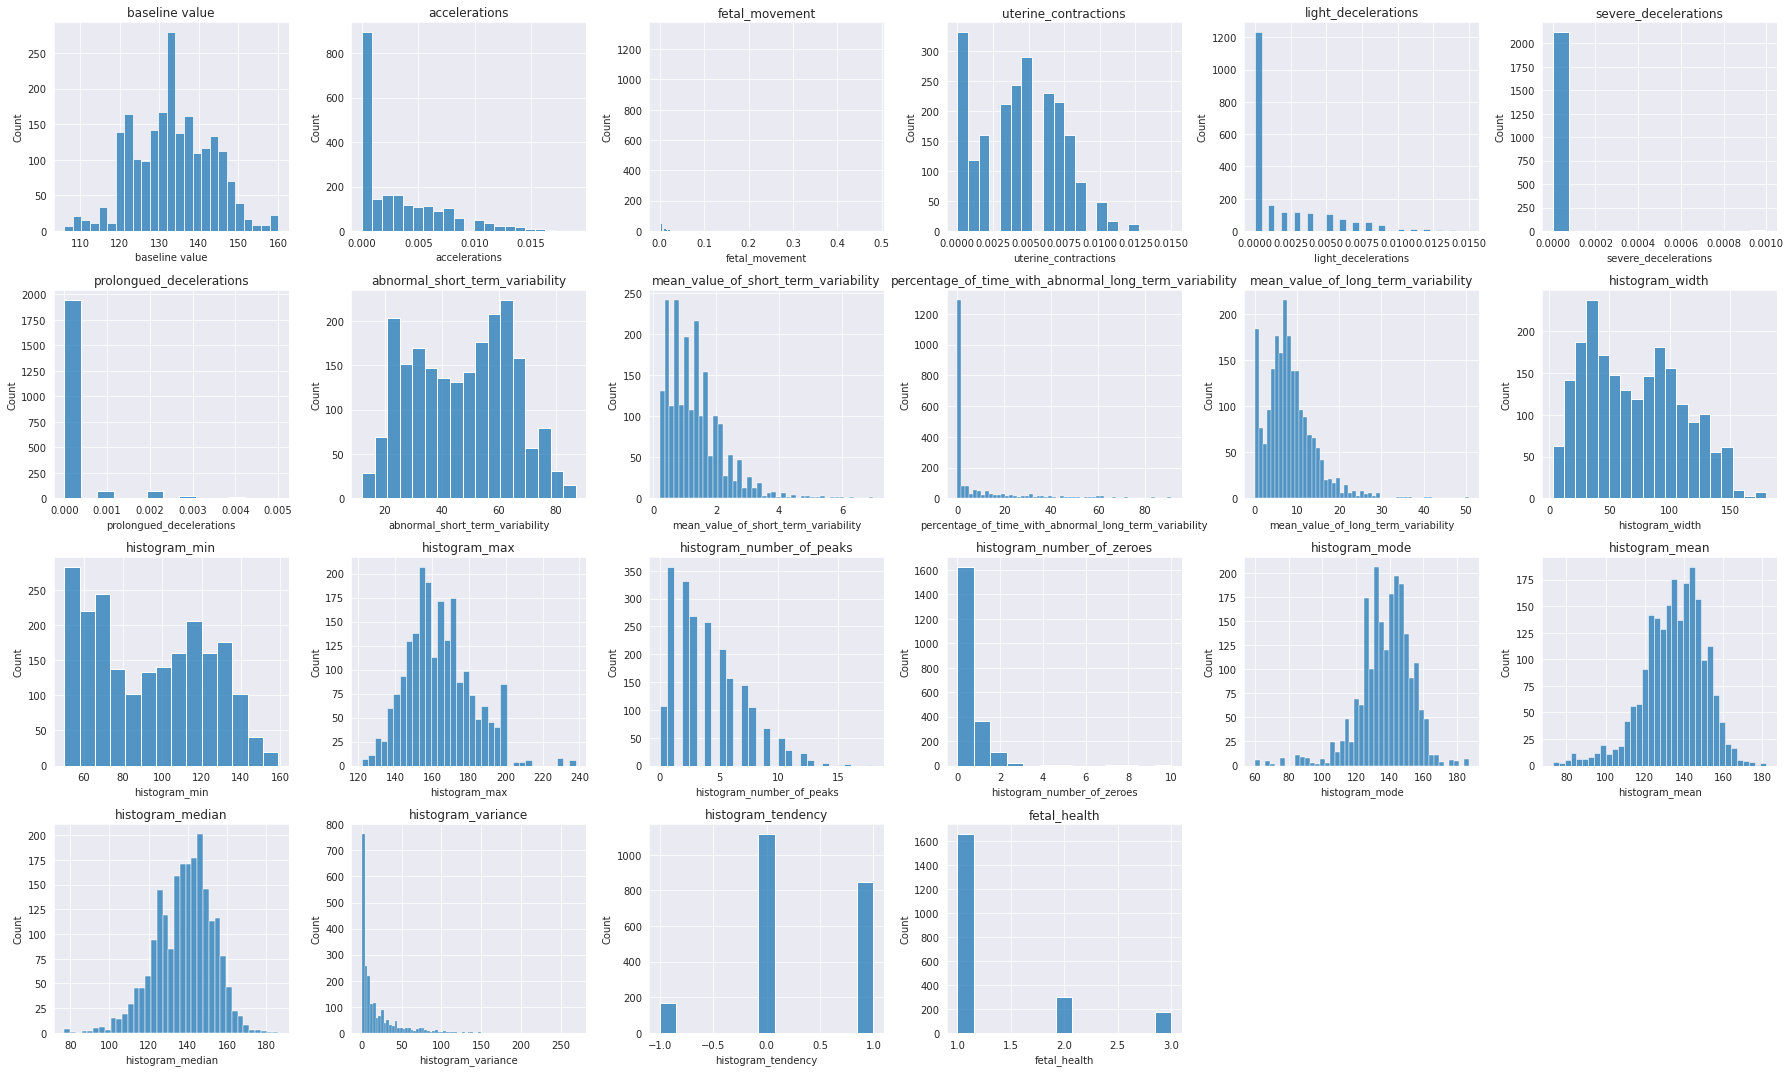

In [6]:
plt.figure(figsize=(25, 15))

for i, column in enumerate(eda_df.columns):
    plt.subplot(4, 6, i + 1)
    sns.histplot(data=eda_df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

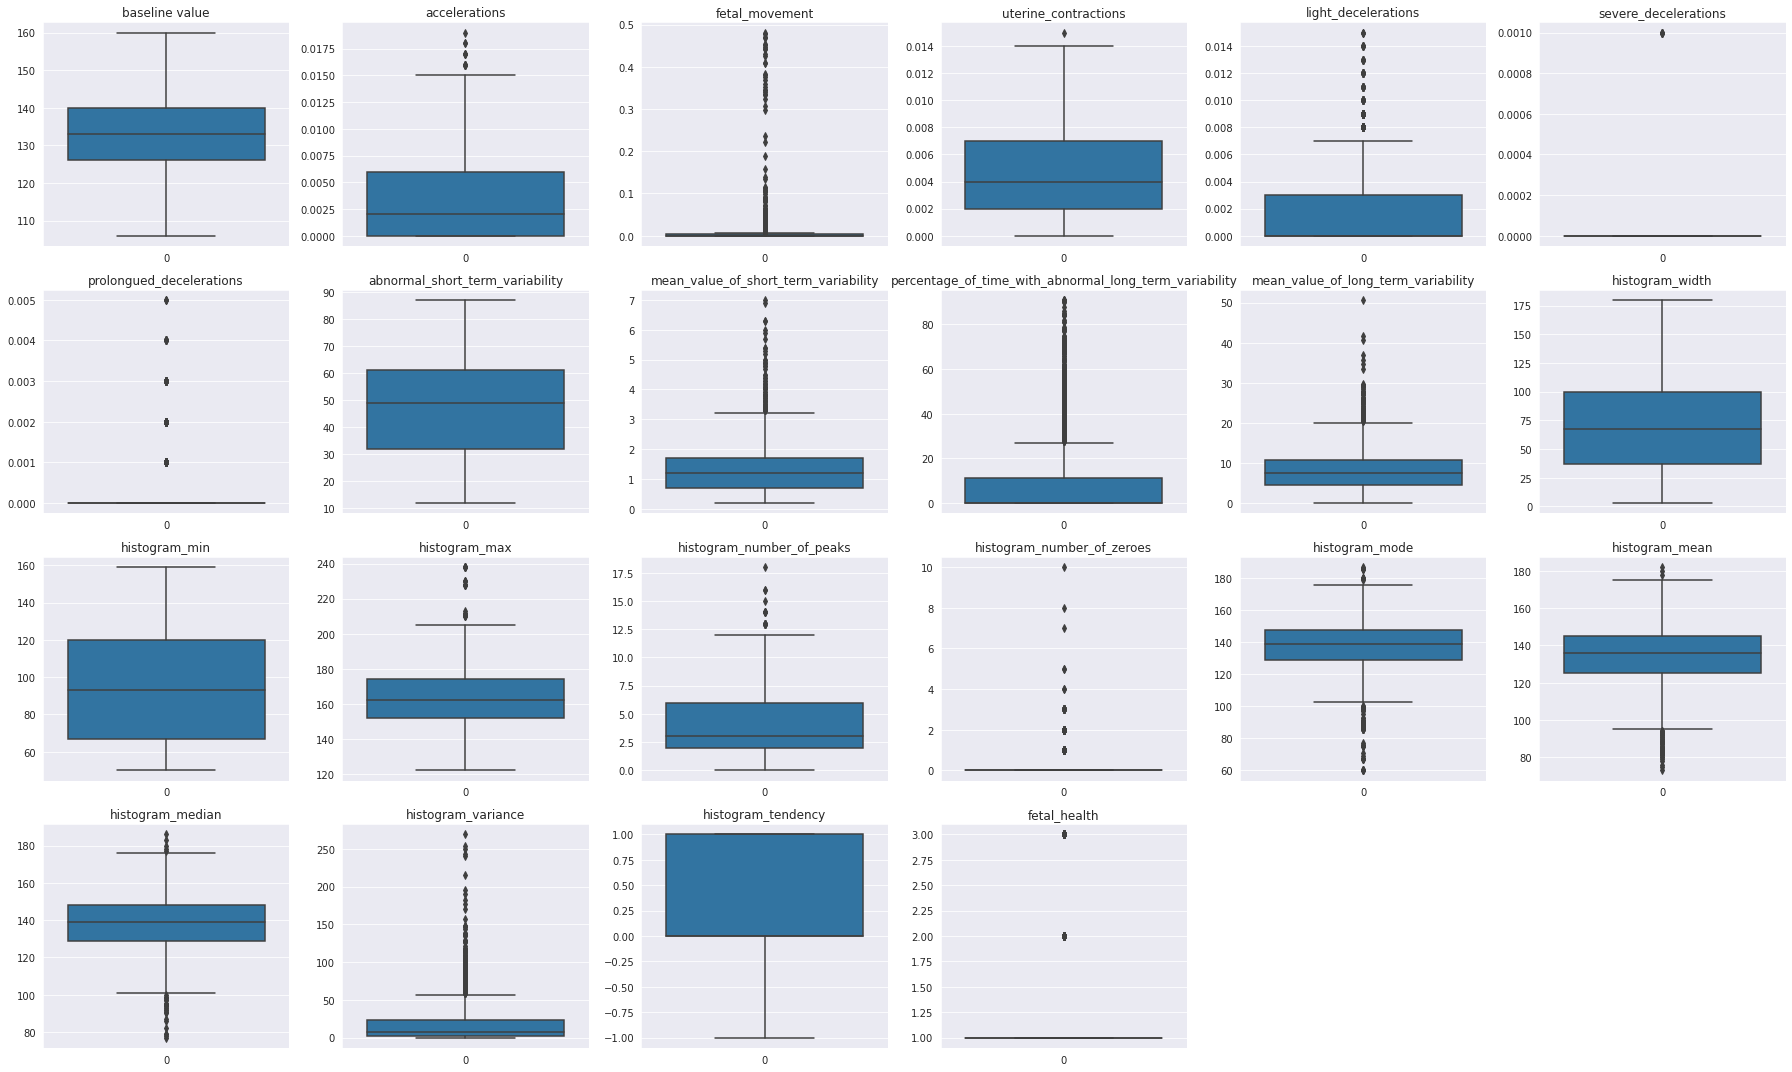

In [7]:
plt.figure(figsize=(25, 15))

for i, column in enumerate(eda_df.columns):
    plt.subplot(4, 6, i + 1)
    sns.boxplot(data=eda_df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

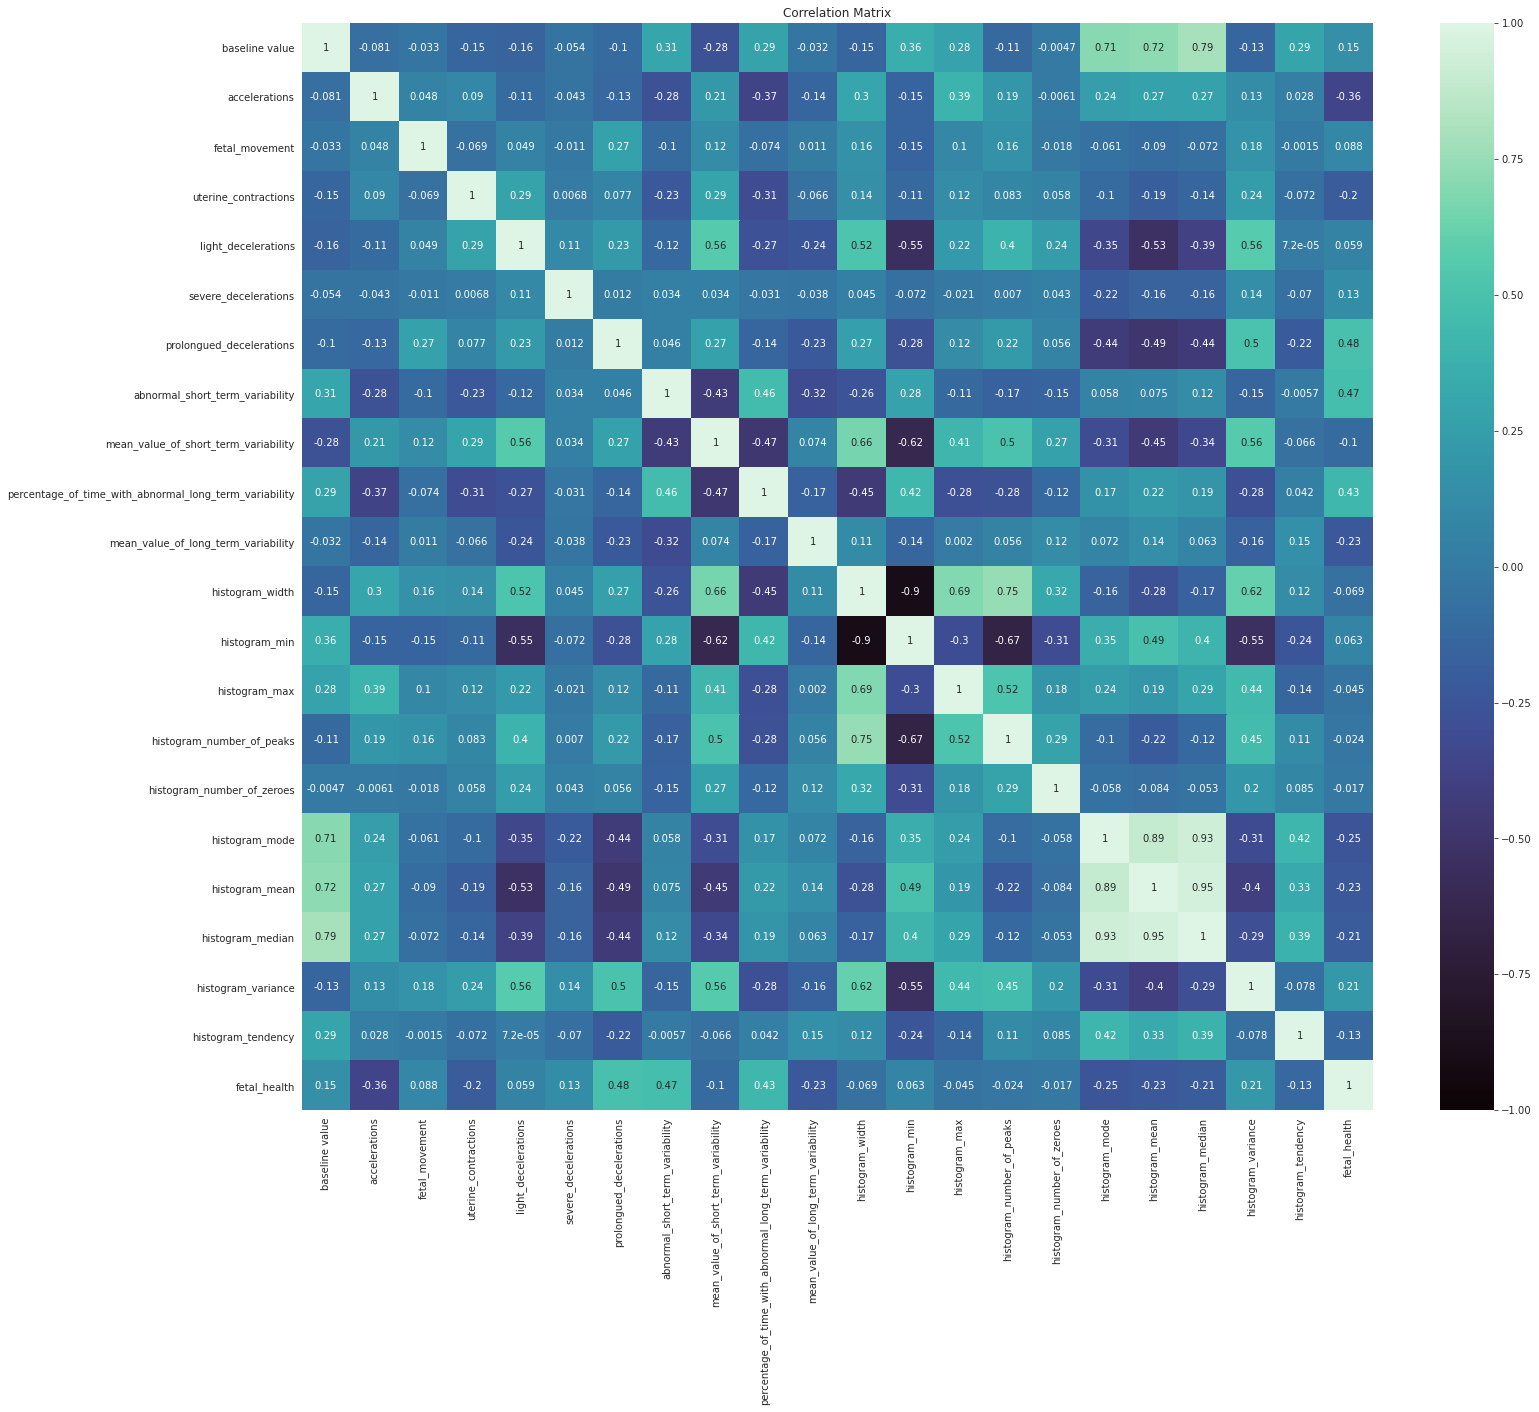

In [8]:
corr = eda_df.corr()

plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title("Correlation Matrix")
plt.show()

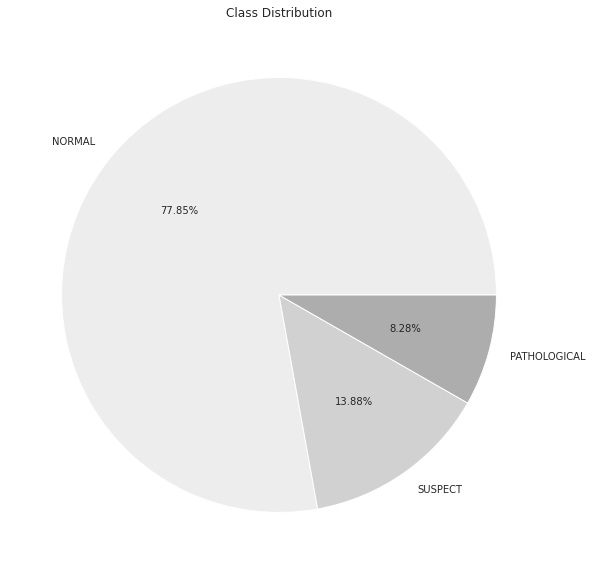

In [9]:
plt.figure(figsize=(10, 10))

plt.pie(
    eda_df['fetal_health'].value_counts(),
    autopct='%.2f%%',
    labels=["NORMAL", "SUSPECT", "PATHOLOGICAL"],
    colors=sns.color_palette('Greys')
)

plt.title("Class Distribution")
plt.show()

# Preprocessing

In [10]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Rename target values
    df['fetal_health'] = df['fetal_health'].replace({
        1.0: "NORMAL",
        2.0: "SUSPECT",
        3.0: "PATHOLOGICAL"
    })
    
    # Split df into X and y
    y = df['fetal_health']
    X = df.drop('fetal_health', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [12]:
X_train

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
1178,-0.754973,0.731770,-0.204095,0.551513,-0.651135,-0.051917,-0.277438,-1.269308,0.073240,-0.537234,-0.324758,-0.595014,0.477137,-0.506937,-0.716047,-0.454252,-0.263063,0.035465,-0.208156,-0.340585,-0.525276
408,1.740547,-0.822284,-0.204095,-1.477290,-0.316227,-0.051917,-0.277438,1.688720,-1.297591,1.827866,-0.522608,-0.931081,1.023066,-0.338574,-1.061197,-0.454252,1.019938,1.198135,1.178619,-0.618965,1.096324
802,1.324627,-0.822284,-0.204095,0.551513,-0.651135,-0.051917,-0.277438,1.050714,-1.069119,1.277843,-0.126908,-1.060338,1.398392,-0.001848,-1.061197,-0.454252,0.775557,0.939764,0.901264,-0.618965,-0.525276
22,-0.547013,-0.822284,7.146148,-0.462889,0.353589,-0.051917,4.696388,-0.747303,1.329835,-0.537234,-0.738444,1.912562,-1.331252,1.962388,2.390302,0.936543,-3.806591,-2.289874,-2.496335,4.496267,-2.146877
204,-1.378853,-0.822284,-0.028041,-1.477290,-0.651135,-0.051917,-0.277438,0.238707,-0.726411,0.287801,-0.126908,-1.293000,0.545379,-1.909963,-1.061197,0.936543,-0.874016,-0.868833,-1.040221,-0.653763,-0.525276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,-0.027113,-0.822284,-0.204095,0.551513,2.363036,-0.051917,-0.277438,-1.559311,1.558307,-0.537234,1.869579,0.697551,-1.024167,-0.170211,1.009703,-0.454252,-0.079777,-0.675055,-0.277495,1.468885,1.096324
905,1.324627,-0.822284,-0.204095,0.889646,1.023405,-0.051917,-0.277438,-0.979305,-0.269468,-0.537234,-0.612540,-0.310650,0.204173,-0.338574,-0.370897,-0.454252,0.592271,0.552207,0.623909,-0.479775,1.096324
1096,-1.066913,3.580871,-0.204095,-0.801023,-0.651135,-0.051917,-0.277438,-1.327308,0.987127,-0.537234,-1.152131,-0.491609,0.238294,-0.675300,-1.061197,-0.454252,-0.079777,-0.093720,-0.208156,-0.479775,-0.525276
235,-1.274873,-0.045257,-0.072054,-1.477290,-0.651135,-0.051917,-0.277438,0.528709,-0.840647,-0.427229,0.430670,0.154673,-1.058287,-1.404874,-0.370897,-0.454252,-0.629635,-0.416684,-0.624189,-0.549370,1.096324


In [13]:
y_train

1178          NORMAL
408          SUSPECT
802          SUSPECT
22      PATHOLOGICAL
204           NORMAL
            ...     
960           NORMAL
905           NORMAL
1096          NORMAL
235           NORMAL
1061          NORMAL
Name: fetal_health, Length: 1488, dtype: object

# Training

In [14]:
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                        Neural Network": MLPClassifier(),
    "                         Random Forest": RandomForestClassifier(),
    "                     Gradient Boosting": GradientBoostingClassifier(),
    "                               XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "                              LightGBM": LGBMClassifier(),
    "                              CatBoost": CatBoostClassifier(verbose=0)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                        Neural Network trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.
                              LightGBM trained.
                              CatBoost trained.


# Results

In [15]:
for name, model in models.items():
    print(name + ": {:.2f}%".format(model.score(X_test, y_test) * 100))

                   Logistic Regression: 90.13%
                   K-Nearest Neighbors: 89.97%
                         Decision Tree: 91.38%
Support Vector Machine (Linear Kernel): 89.03%
   Support Vector Machine (RBF Kernel): 91.07%
                        Neural Network: 92.01%
                         Random Forest: 93.26%
                     Gradient Boosting: 94.98%
                               XGBoost: 94.98%
                              LightGBM: 94.67%
                              CatBoost: 94.20%


# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/_7z2REeVxeU